In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Dropout, MaxPool1D, ReLU, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

2025-07-10 19:20:48.619785: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-10 19:20:49.063112: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
no_of_merged_samples = 5000
no_of_params = 2

In [3]:
signal_bbh_df = pd.read_csv("C:/Users/sunda/Documents/Github/Gravitational Wave Detection/scripts/raw-data-files/Final_BBH_Merged_Noise_Signal_Reduced_No_ABS.csv", header=None)
signal_bbh = signal_bbh_df.astype(float)

noise_df = pd.read_csv("C:/Users/sunda/Documents/Github/Gravitational Wave Detection/scripts/raw-data-files/Final_Merged_Noise_Reduced_No_Abs.csv",header = None)
noise = noise_df.astype(float)

val_signal_df = pd.read_csv("C:/Users/sunda/Documents/Github/Gravitational Wave Detection/scripts/raw-val-data-files/val_Final_BBH_Merged_Noise_Signal_Reduced_No_ABS.csv", header = None)
val_signal_bbh = val_signal_df.astype(float)

val_noise_df = pd.read_csv("C:/Users/sunda/Documents/Github/Gravitational Wave Detection/scripts/raw-val-data-files/val_Final_Merged_Noise_Reduced_No_Abs.csv", header = None)
val_noise = val_noise_df.astype(float)

In [4]:
print(signal_bbh.shape)
print(noise.shape)
print(val_signal_bbh.shape)
print(val_noise.shape)

(5000, 16384)
(5000, 16384)
(1000, 16384)
(1000, 16384)


In [5]:
signal_bbh['label'] = 1
noise['label'] = 0
val_signal_bbh['label'] = 1
val_noise['label'] = 0

In [6]:
combined_data = pd.concat([signal_bbh, noise], axis = 0).reset_index(drop = True)
combined_val_data = pd.concat([val_signal_bbh, val_noise], axis = 0).reset_index(drop = True)

In [7]:
shuffled_data = shuffle(combined_data, random_state=42)
shuffled_val_data = shuffle(combined_val_data, random_state=42)

In [8]:
shuffled_data.to_csv("C:/Users/sunda/Documents/Github/Gravitational Wave Detection/scripts/raw-data-files/Final_Shuffled_Data.csv", index=False, header=False)
shuffled_val_data.to_csv("C:/Users/sunda/Documents/Github/Gravitational Wave Detection/scripts/raw-data-files/Final_Shuffled_Val_Data.csv", index=False, header=False)

In [8]:
X = shuffled_data.iloc[:, :-1] 
#X *= 1e19
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = shuffled_data.iloc[:, -1]    

X_v = shuffled_val_data.iloc[:, :-1]
X_v = scaler.transform(X_v)
y_v = shuffled_val_data.iloc[:, -1]

In [9]:
X_train, _, y_train, _ = train_test_split(X, y, test_size=1) #, random_state=1
X_val, _, y_val, _     = train_test_split(X_v , y_v, test_size=1) #, random_state=1

In [16]:
model = Sequential()
model.add(Conv1D(16, 16, input_shape=(16384, 1)))
model.add(MaxPool1D(4, 4))
model.add(ReLU())
model.add(Dropout(0.2))
model.add(Conv1D(32, 8))
model.add(MaxPool1D(4, 4))
model.add(ReLU())
model.add(Dropout(0.2))
model.add(Conv1D(64, 8))
model.add(MaxPool1D(4, 4))
model.add(ReLU())
model.add(Dropout(0.2))
model.add(Conv1D(128, 8))
model.add(MaxPool1D(4, 4))
model.add(ReLU())
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid')) # ✅ Only 1 output neuron

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 16369, 16)         272       
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 4092, 16)          0         
 g1D)                                                            
                                                                 
 re_lu_4 (ReLU)              (None, 4092, 16)          0         
                                                                 
 conv1d_5 (Conv1D)           (None, 4085, 32)          4128      
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 1021, 32)          0         
 g1D)                                                            
                                                                 
 re_lu_5 (ReLU)              (None, 1021, 32)         

In [56]:
if X_train.ndim == 2:
    X_train = np.expand_dims(X_train, axis=-1)
if X_val.ndim == 2:
    X_val = np.expand_dims(X_val, axis=-1)

y_train = y_train.astype(np.float32)
y_val = y_val.astype(np.float32)

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    batch_size=64, epochs=20,
                    callbacks=[early_stop])

Epoch 1/10


2025-07-10 17:50:48.803442: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2025-07-10 17:50:52.914689: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2025-07-10 17:50:53.085135: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x77506caffec0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-07-10 17:50:53.085204: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-07-10 17:50:53.188924: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-10 17:50:53.652379: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifeti

79/79 [==============================] - 41s 319ms/step - loss: 0.0766
Epoch 2/10
79/79 [==============================] - 24s 301ms/step - loss: 0.0021
Epoch 3/10
79/79 [==============================] - 26s 325ms/step - loss: 0.0015
Epoch 4/10
79/79 [==============================] - 27s 336ms/step - loss: 0.0014
Epoch 5/10
79/79 [==============================] - 27s 346ms/step - loss: 0.0010
Epoch 6/10
79/79 [==============================] - 27s 338ms/step - loss: 8.7318e-04
Epoch 7/10
79/79 [==============================] - 28s 354ms/step - loss: 7.4434e-04
Epoch 8/10
79/79 [==============================] - 28s 352ms/step - loss: 6.2563e-04
Epoch 9/10
79/79 [==============================] - 29s 366ms/step - loss: 5.3721e-04
Epoch 10/10
79/79 [==============================] - 30s 375ms/step - loss: 5.8998e-04


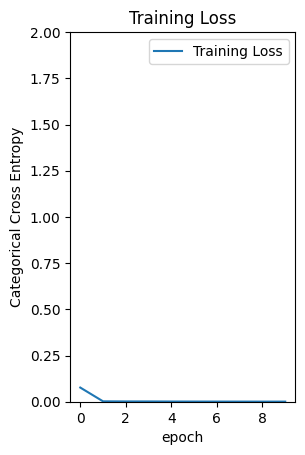

In [57]:
loss, accuracy = model.evaluate(X_val, y_val)
print(f"✅ Validation Accuracy: {accuracy * 100:.2f}%")